In [1]:
import os
import pandas as pd
import ast
import numpy as np

In [2]:
import librosa

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
from collections import defaultdict
import pickle

In [5]:
import numpy as np
import pandas as pd
import re

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

In [8]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [9]:
from IPython.display import Image as PImage

In [10]:
from subprocess import check_call

In [11]:
from PIL import Image, ImageDraw, ImageFont

In [12]:
import lightgbm as lgbm

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [14]:
#I took help from github link: https://github.com/celestinhermez/music-genre-classification/blob/master/data_preprocessing/create_audio_features.ipynb
# path to the small directory
SMALL_AUDIO_DIR = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small'

# function to get the paths to all the songs in the small dataset
def audio_paths(AUDIO_DIR):
    AUDIO_PATHS = []
    # iterate through all the directories with songs in them
    for path in [os.path.join('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small', p) 
                 for p in os.listdir('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small') 
                 if not (p.endswith('checksums') or p.endswith('.txt') or p.endswith('.DS_Store'))]:
        # add all songs to the list
        AUDIO_PATHS = AUDIO_PATHS + [os.path.join(path, track).replace('\\', '/') for track in os.listdir(path)]
    
    return AUDIO_PATHS

# store all the small paths
SMALL_PATHS = audio_paths(SMALL_AUDIO_DIR)

In [15]:
print(SMALL_PATHS[0:15])

['E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000002.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000005.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000010.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000140.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000141.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000148.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000182.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000190.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000193.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000194.mp3', 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000197.mp3', 'E:/8th Semester/CSE4836-Patter

In [16]:
t=pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/tracks.csv')
t.head(3)

C:\Users\HP\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning:

Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types.Specify dtype option on import or set low_memory=False.



,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food


In [17]:
# function to load metadata
# adapted from https://github.com/mdeff/fma/blob/master/utils.py
def metadata_load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [18]:
# function to get genre information for each track ID
def track_genre_information(GENRE_PATH, TRACKS_PATH, FILE_PATHS, subset):
    """
    GENRE_PATH (str): path to the csv with the genre metadata
    TRACKS_PATH (str): path to the csv with the track metadata
    FILE_PATHS (list): list of paths to the mp3 files
    subset (str): the subset of the data desired
    """
    # get the genre information
    genres = pd.read_csv(GENRE_PATH)

    # load metadata on all the tracks
    tracks = metadata_load(TRACKS_PATH)
    print(tracks.head(5))

    # focus on the specific subset tracks
    subset_tracks = tracks[tracks['set', 'subset'] <= subset]

    # extract track ID and genre information for each track
    subset_tracks_genre = np.array([np.array(subset_tracks.index), 
                                  np.array(subset_tracks['track', 'genre_top'])]).T
    
    # extract track indices from the file paths
    track_indices = []
    for path in FILE_PATHS:
        track_indices.append(path.split('/')[-1].split('.')[0].lstrip('0'))

    # get the genre associated with each file path, thanks to the path ID
    print(track_indices)
    track_indices = pd.DataFrame({'file_path':FILE_PATHS,'track_id':np.array(track_indices).astype(int)})
    tracks_genre_df = pd.DataFrame({'track_id': subset_tracks_genre[:,0], 'genre': subset_tracks_genre[:,1]})
    track_genre_data = track_indices.merge(tracks_genre_df, how='left')
    
    # label classes with numbers
    encoder = LabelEncoder()
    track_genre_data['genre_nb'] = encoder.fit_transform(track_genre_data.genre)
    
    return track_genre_data

# get genre information for all tracks from the small subset
GENRE_PATH = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/genres.csv'
TRACKS_PATH = 'E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_metadata/tracks.csv'
subset = 'small'

small_tracks_genre = track_genre_information(GENRE_PATH, TRACKS_PATH, SMALL_PATHS, subset)

            album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []  

In [19]:
small_tracks_genre.head(4)

,file_path,track_id,genre,genre_nb
0,E:/8th Semester/CSE4836-Pattern Recognition La...,2,Hip-Hop,3
1,E:/8th Semester/CSE4836-Pattern Recognition La...,5,Hip-Hop,3
2,E:/8th Semester/CSE4836-Pattern Recognition La...,10,Pop,6
3,E:/8th Semester/CSE4836-Pattern Recognition La...,140,Folk,2


# Feature-Extraction-1

In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile

In [21]:
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import librosa
import itertools

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [23]:
columns = []
for i in range(0,13):
    columns.append("mean" + str(i))
    for j in range(0,13):
        columns.append("cov" + str(i) + "-" + str(j))
columns.append("Genre")

In [24]:
datafile = pd.DataFrame(columns=columns)
datafile.columns

Index(['mean0', 'cov0-0', 'cov0-1', 'cov0-2', 'cov0-3', 'cov0-4', 'cov0-5',
       'cov0-6', 'cov0-7', 'cov0-8',
       ...
       'cov12-4', 'cov12-5', 'cov12-6', 'cov12-7', 'cov12-8', 'cov12-9',
       'cov12-10', 'cov12-11', 'cov12-12', 'Genre'],
      dtype='object', length=183)

In [25]:
all_genres = small_tracks_genre['genre'].unique()
print(all_genres)

['Hip-Hop' 'Pop' 'Folk' 'Experimental' 'Rock' 'International' 'Electronic'
 'Instrumental']


In [26]:
#Creating a Dictionary of Genres
genres = {
    'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Experimental': 3, 'Rock': 4, 
    'International': 5, 'Electronic': 6, 'Instrumental': 7
}

In [27]:
for ind in small_tracks_genre.index:
  song_link = small_tracks_genre['file_path'][ind]
  song_genre = small_tracks_genre['genre'][ind]
  signal, rate = librosa.load(song_link)
  # Debug process
  print("Reading file: {}".format(song_link))
  mfcc_feat = mfcc(signal,rate ,winlen=0.020, appendEnergy = False)
  covariance = np.cov(np.matrix.transpose(mfcc_feat))
  mean_matrix = mfcc_feat.mean(0)
  row_element = []

  #flattening the array
  for i in range(0,13):
    row_element.append(mean_matrix[i])
    for j in range(0,13):
      row_element.append(covariance[i][j])
  row_element.append(genres[song_genre])

  #adding to the dataframe
  data_to_append = {}
  for i in range(len(datafile.columns)):
    data_to_append[datafile.columns[i]] = row_element[i]
  datafile = datafile.append(data_to_append, ignore_index = True)


C:\Users\HP\Anaconda\lib\site-packages\librosa\core\audio.py:162: UserWarning:

PySoundFile failed. Trying audioread instead.



Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000002.mp3


C:\Users\HP\Anaconda\lib\site-packages\librosa\core\audio.py:162: UserWarning:

PySoundFile failed. Trying audioread instead.



Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000005.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000010.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000140.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000148.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000182.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000190.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000193.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000194.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/000/000197.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001482.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001510.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001544.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001642.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001644.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001661.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001663.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/001/001666.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003896.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003904.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003905.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003906.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003908.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003909.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003910.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003911.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003912.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/003/003913.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/004/004849.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005006.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005156.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005158.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005159.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005169.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005170.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005171.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/005/005191.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006802.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006803.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006854.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006855.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006856.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/006/006857.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007011.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007373.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007374.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/007/007375.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010381.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010382.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010383.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010384.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010385.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010386.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010387.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010388.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/010/010435.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011544.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011671.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011672.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011673.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011674.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011675.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011677.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011679.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/011/011681.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012109.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012173.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012174.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012179.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012188.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012189.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012346.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/012/012348.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013748.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013749.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013804.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013929.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/013/013930.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/014/014063.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015625.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015769.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015770.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015771.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015772.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/015/015880.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/016/016095.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/016/016155.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/016/016158.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/018/018887.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019073.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019074.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019179.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019184.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019187.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019192.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019412.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019413.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/019/019415.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021997.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021998.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/021/021999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022088.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022091.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022093.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022094.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/022/022095.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024739.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024741.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024742.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024745.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024746.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024747.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024748.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024749.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024842.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/024/024898.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026639.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026640.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026641.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026642.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026643.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026651.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026652.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026653.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/026/026654.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028553.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028608.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/028/028802.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/029/029037.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/029/029039.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/029/029040.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031044.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031165.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031356.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031390.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031391.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031392.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031807.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/031/031887.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034257.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034258.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034484.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034510.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034511.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034994.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/034/034996.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/035/035007.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036992.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036994.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036997.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036998.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/036/036999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037041.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037111.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037113.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037119.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/037/037121.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038881.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038882.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038886.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038887.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038888.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038890.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038891.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038892.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/038/038893.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040239.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040242.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040244.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040245.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040250.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040509.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/040/040525.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042234.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042235.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042236.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042245.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/042/042247.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043765.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043766.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043796.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043842.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043843.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043844.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/043/043856.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045119.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045122.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045125.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045126.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045127.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045128.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045149.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045150.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045151.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/045/045152.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047193.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047194.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047195.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047196.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047197.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047198.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047199.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047200.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047201.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/047/047202.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/048/048990.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/048/048999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049029.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049030.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049039.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049061.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049062.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049064.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049066.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/049/049067.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051275.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051276.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051292.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051301.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051305.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051333.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051479.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/051/051655.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052648.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052650.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052859.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052860.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052861.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052862.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/052/052947.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054376.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054433.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054436.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054437.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054438.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054442.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054463.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054464.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/054/054465.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055436.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055437.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055480.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055481.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055572.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055709.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055710.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055711.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/055/055712.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056686.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056687.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056688.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056689.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056690.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056691.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056693.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056694.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/056/056695.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058061.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058063.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058068.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058070.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058115.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058116.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058117.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058135.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058140.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/058/058161.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059720.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059721.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059723.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059724.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059725.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059726.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059823.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/059/059930.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061734.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061736.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061742.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061814.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061820.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061821.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/061/061884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/062/062001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/062/062003.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/062/062005.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063290.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063292.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063456.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063457.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063470.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063471.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/063/063472.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064630.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064631.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064659.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064787.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064789.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064796.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064809.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064834.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/064/064840.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066638.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066641.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066643.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066644.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066646.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066648.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066649.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066650.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066689.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/066/066690.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068539.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068540.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068541.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068543.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068573.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068579.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068582.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/068/068587.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069726.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069732.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069744.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069745.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069746.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069747.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069761.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069762.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/069/069763.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071231.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071241.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071242.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071243.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071244.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071245.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071246.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071247.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/071/071248.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072210.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072215.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072232.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072233.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072234.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072288.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072290.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/072/072456.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073560.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073561.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073564.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073565.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073566.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073572.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073573.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073580.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/073/073584.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/074/074960.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075194.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075211.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075230.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075304.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075310.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075314.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075317.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075371.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075883.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075903.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075908.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075925.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075926.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075929.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075930.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/075/075931.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080002.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080003.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080004.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080005.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080035.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080293.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080341.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/080/080351.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081868.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081895.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081938.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081988.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/081/081999.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/082/082157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/082/082231.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/082/082237.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084142.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084144.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084152.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084154.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084155.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084156.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084158.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/084/084159.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085692.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085693.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085787.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085791.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085792.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085816.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085817.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085822.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/085/085823.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087068.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087069.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087070.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087096.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087097.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087098.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087099.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087100.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087101.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/087/087102.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088878.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088879.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088892.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088899.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088900.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088959.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/088/088960.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/089/089178.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091092.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091093.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091098.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091102.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091130.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091157.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091158.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091159.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091160.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/091/091161.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092508.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092535.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092536.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092538.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092539.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092540.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/092/092551.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094101.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094102.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094348.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094411.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094414.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094415.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094419.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094422.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/094/094423.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096901.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096902.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096935.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096936.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096944.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/096/096946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/097/097037.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/097/097041.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/097/097043.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098238.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098251.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098297.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098298.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098299.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098300.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098301.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098302.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098339.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/098/098346.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099369.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099370.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099371.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099372.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099373.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099374.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099375.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099390.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/099/099391.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104276.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104277.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104279.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104282.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104283.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104284.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104356.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/104/104357.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106568.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106569.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106570.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106629.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106872.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106937.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/106/106948.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107590.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107591.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107592.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107593.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107594.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107595.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107596.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107597.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107598.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/107/107613.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108415.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108416.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108418.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108420.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108421.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108422.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108423.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108426.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108427.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108883.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108884.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108885.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108906.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108957.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108961.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108962.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108967.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108968.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/108/108969.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110107.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110108.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110109.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110110.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110111.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110166.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110171.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110172.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110204.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110927.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110928.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110980.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110982.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110983.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/110/110985.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111015.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111146.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/111/111148.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112001.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112020.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112065.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112066.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112088.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112133.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112196.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112197.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/112/112198.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113165.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113166.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113167.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113203.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113259.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113260.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113262.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/113/113264.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114041.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114042.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114044.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114045.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114047.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114048.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114049.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114050.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114051.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114061.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114403.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114404.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114405.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114406.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114408.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114409.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114410.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114411.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114412.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/114/114413.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115765.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115766.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115767.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115768.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115769.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115771.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115772.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115773.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115774.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/115/115775.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116514.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116517.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116525.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116526.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116527.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116528.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116547.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116586.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/116/116587.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117944.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117945.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117946.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117961.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117966.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117967.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117970.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/117/117991.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/118/118000.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/118/118012.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119257.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119369.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119379.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119413.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119545.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119569.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119571.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119574.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119575.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/119/119578.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120307.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120308.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120309.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120310.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120312.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120313.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120314.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120315.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120316.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/120/120317.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121591.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121592.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121593.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121594.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121595.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121651.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121652.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121653.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121654.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/121/121655.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122365.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122395.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122397.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122398.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122399.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122400.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122456.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122457.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122472.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/122/122473.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123147.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123273.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123278.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123333.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123342.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123427.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123438.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123439.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123440.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/123/123441.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124184.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124185.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124186.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124201.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124231.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124391.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124392.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124393.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124394.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/124/124409.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125239.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125240.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125286.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125287.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125288.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125289.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125291.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125293.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125298.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/125/125299.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126219.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126220.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126223.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126224.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126225.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126226.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126229.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126230.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126586.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126587.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126588.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126589.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126598.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126600.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126601.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126602.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126603.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/126/126605.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127263.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127266.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127267.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127269.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127271.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127273.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127274.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127275.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127911.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127912.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127913.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127914.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127915.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127916.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127936.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/127/127996.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/128/128441.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/128/128443.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129186.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129187.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129188.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129189.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129190.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129362.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129372.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129374.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/129/129375.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130135.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130136.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130137.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130168.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130170.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130218.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130347.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130349.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/130/130367.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131444.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131446.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131448.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131449.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131451.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131452.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131453.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131454.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131476.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/131/131536.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132134.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132138.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132139.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132140.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132141.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132142.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132171.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132272.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132310.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/132/132420.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133439.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133440.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133441.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133442.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133444.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133445.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133446.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133447.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/133/133448.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134084.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134094.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134359.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134384.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134385.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134388.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134389.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134443.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134444.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/134/134445.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135221.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135222.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135223.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135224.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135225.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135226.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135227.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135228.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135229.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/135/135336.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137424.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137426.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137462.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137463.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137484.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137500.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137561.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/137/137563.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138318.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138319.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138320.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138351.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138355.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138406.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138410.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138413.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138414.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/138/138415.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140583.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140584.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140609.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140620.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140621.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140623.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140625.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140626.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140788.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/140/140789.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141875.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141876.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141877.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141878.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141894.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141901.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141902.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141903.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/141/141972.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142078.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142671.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142672.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142947.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142948.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142949.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/142/142950.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143039.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143046.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143055.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/143/143056.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144545.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144546.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144547.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144548.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144549.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144550.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144551.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144552.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144587.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/144/144592.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145707.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145708.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145709.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145710.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145711.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145724.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145727.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145728.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145729.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/145/145730.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147126.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147191.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147265.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147267.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147268.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147269.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147295.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147309.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/147/147409.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148536.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148537.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148584.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148585.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148586.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148587.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148602.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148603.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148604.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/148/148605.mp3
Reading fi

Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152254.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152258.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152261.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152262.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152324.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152418.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152425.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152480.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152543.mp3
Reading file: E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/fma_small/152/152545.mp3
Reading fi

In [28]:
datafile.shape

(7997, 183)

In [29]:
datafile.head(5)

,mean0,cov0-0,cov0-1,cov0-2,cov0-3,cov0-4,cov0-5,cov0-6,cov0-7,cov0-8,...,cov12-4,cov12-5,cov12-6,cov12-7,cov12-8,cov12-9,cov12-10,cov12-11,cov12-12,Genre
0,-25.163149,34.313855,-12.378964,18.260935,-8.566435,5.506471,14.855159,-5.462720,25.967193,27.663296,...,19.123418,1.916578,-3.066154,4.204667,5.162911,-4.496266,5.927454,28.160564,78.742818,0.0
1,-29.122103,27.560623,-16.372075,3.279927,-9.362722,-1.431465,8.236138,-8.361545,13.065171,19.782244,...,31.782561,10.247662,-8.283588,-9.258754,-6.801542,-5.867159,13.643951,27.537176,104.548706,0.0
2,-19.995305,8.808189,-10.779887,14.088983,-7.138095,8.237542,1.382340,5.891247,4.109863,6.654157,...,8.792430,2.786573,10.306992,2.049482,2.143831,0.897288,10.476140,16.785422,58.374128,1.0
3,-46.187465,95.196774,-37.018831,-40.569754,-40.276932,4.452968,-47.831260,30.472470,-2.791073,-2.244438,...,-30.390691,33.420974,-55.184531,22.940160,2.866588,-23.239544,-23.366884,52.332281,126.211050,2.0
4,-38.416686,159.801559,-71.132656,-22.576132,-11.244879,-47.555446,43.018315,-28.961821,14.242021,20.413391,...,-31.196568,39.639426,-35.424495,30.521208,22.969927,16.861451,-3.309800,42.858532,115.986239,2.0


In [30]:
datafile['Genre'].value_counts()

7.0    1000
5.0    1000
2.0    1000
1.0    1000
0.0    1000
6.0     999
4.0     999
3.0     999
Name: Genre, dtype: int64

In [31]:
datafile.to_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/NewApproach/dataframe1.csv', index=False)

# Decision Tree

In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
datafile_tree = pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/NewApproach/dataframe1.csv')
train_tree, test_tree = train_test_split(datafile_tree, test_size=0.20)
train_tree.shape,test_tree.shape

((6397, 183), (1600, 183))

In [5]:
X_train = train_tree.drop(['Genre'], axis=1).values
y_train = train_tree['Genre'].values
X_test = test_tree.drop(['Genre'], axis=1).values
y_test = test_tree['Genre'].values

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier

In [39]:
parameters = {
    "classifier__criterion": ["entropy", "gini"],
    "classifier__splitter": ["random", "best"],
}

pipeline_tree = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('classifier', DecisionTreeClassifier())
])

grid_tree = GridSearchCV(pipeline_tree, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__splitter': ['random', 'best']},
             scoring='accuracy')

In [40]:
print("Best Parameters = ",grid_tree.best_params_)
print("Accuracy over Train set = ",grid_tree.best_score_)
y_pred = grid_tree.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'classifier__criterion': 'gini', 'classifier__splitter': 'best'}
Accuracy over Train set =  0.30545677775605945
Accuracy over Test set =  0.311875


In [41]:
import joblib
joblib.dump(grid_tree.best_params_, 'grid_tree_1.pkl', compress = 1)
grid_tree_1_params = joblib.load('grid_tree_1.pkl')
print(grid_tree_1_params)

{'classifier__criterion': 'gini', 'classifier__splitter': 'best'}


In [42]:
#Variance Thresholding 
var_thres = VarianceThreshold(threshold=(.8 * (1 - .8)))
thres_X = var_thres.fit_transform(X_train)

#Feature Selection
lgb = lgbm.LGBMClassifier(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
feat_selection = SelectFromModel(lgb, prefit=True)
X_train = feat_selection.transform(thres_X)

In [43]:
thres_X = var_thres.fit_transform(X_test)
X_test = feat_selection.transform(thres_X)

In [44]:
decision_tree_clf = DecisionTreeClassifier(criterion='entropy',splitter='best')
decision_tree_clf.fit(X_train,y_train)
y_pred = decision_tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.329375

In [18]:
target_names = ['Hip-Hop', 'Pop', 'Folk', 'Experimental','Rock','International','Electronic','Instrumental']

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      Hip-Hop       0.40      0.44      0.42       178
          Pop       0.21      0.19      0.20       213
         Folk       0.39      0.42      0.41       193
 Experimental       0.19      0.20      0.19       200
         Rock       0.43      0.39      0.41       212
International       0.34      0.33      0.34       197
   Electronic       0.35      0.33      0.34       207
 Instrumental       0.33      0.35      0.34       200

     accuracy                           0.33      1600
    macro avg       0.33      0.33      0.33      1600
 weighted avg       0.33      0.33      0.33      1600



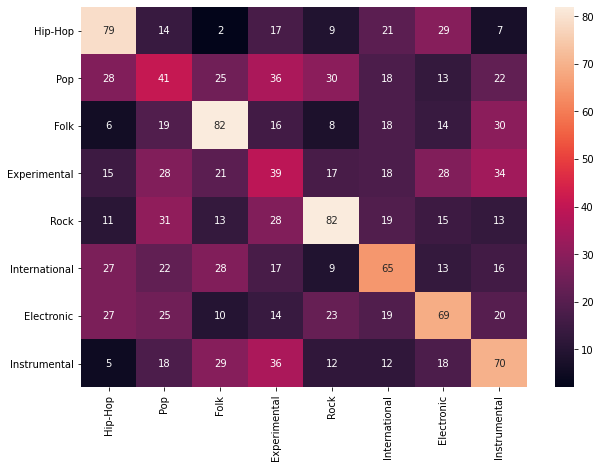

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# KNN-Algorithm

In [1]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#importing train_test_split
from sklearn.model_selection import train_test_split

In [2]:
datafile_knn = pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/NewApproach/dataframe1.csv')
train_knn, test_knn = train_test_split(datafile_knn, test_size=0.20)
train_knn.shape,test_knn.shape

((6397, 183), (1600, 183))

In [3]:
X_train = train_knn.drop(['Genre'], axis=1).values
y_train = train_knn['Genre'].values
X_test = test_knn.drop(['Genre'], axis=1).values
y_test = test_knn['Genre'].values

In [4]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

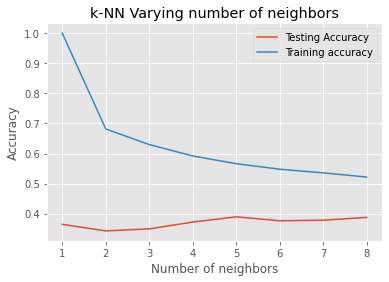

In [5]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [6]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=2)
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [7]:
knn.score(X_test,y_test)

0.3425

In [11]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [14]:
print("Best Parameters = ",grid_knn.best_params_)
print("Accuracy over Train set = ",grid_knn.best_score_)
y_pred = grid_knn.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'n_neighbors': 17, 'weights': 'distance'}
Accuracy over Train set =  0.4159807805164319
Accuracy over Test set =  0.391875


In [15]:
import joblib
joblib.dump(grid_knn.best_params_, 'grid_knn_1.pkl', compress = 1)
grid_knn_1_params = joblib.load('grid_knn_1.pkl')
print(grid_knn_1_params)

{'n_neighbors': 17, 'weights': 'distance'}


In [16]:
knn_clf = KNeighborsClassifier(n_neighbors= 17, weights= 'distance')
knn_clf.fit(X_train,y_train)
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.391875

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

      Hip-Hop       0.39      0.60      0.47       199
          Pop       0.33      0.23      0.27       194
         Folk       0.40      0.49      0.44       187
 Experimental       0.41      0.18      0.25       204
         Rock       0.41      0.63      0.50       195
International       0.33      0.36      0.35       225
   Electronic       0.41      0.41      0.41       192
 Instrumental       0.53      0.25      0.34       204

     accuracy                           0.39      1600
    macro avg       0.40      0.39      0.38      1600
 weighted avg       0.40      0.39      0.38      1600



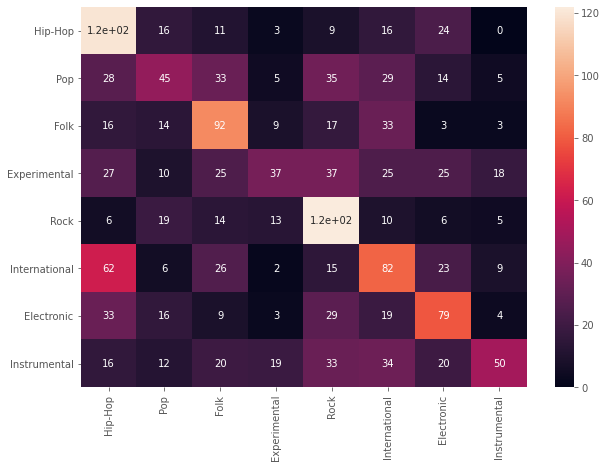

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confusion_matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Support Vector Machine

In [21]:
import pandas as pd 
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn

%matplotlib inline

In [22]:
datafile_svm = pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/NewApproach/dataframe1.csv')
train_svm, test_svm = train_test_split(datafile_svm, test_size=0.20)
train_svm.shape,test_svm.shape

((6397, 183), (1600, 183))

In [23]:
X_train = train_svm.drop(['Genre'], axis=1).values
y_train = train_svm['Genre'].values
X_test = test_svm.drop(['Genre'], axis=1).values
y_test = test_svm['Genre'].values

In [24]:
print(X_train.shape, X_test.shape)

(6397, 182) (1600, 182)


In [25]:
#Here I will tune hyperparameter for linear,sigmoid and poly
parameters = {
    "clf__C": [0.5, 1, 2, 5],
    "clf__kernel": ['poly', 'linear', 'sigmoid'],  #did rbf in separate block as to avoid gamma calculation for these three
}

pipeline_svm = Pipeline([
    ('scaling', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('clf', SVC())
])

grid_svm = GridSearchCV(pipeline_svm, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('clf', SVC())]),
             n_jobs=6,
             param_grid={'clf__C': [0.5, 1, 2, 5],
                         'clf__kernel': ['poly', 'linear', 'sigmoid']},
             scoring='accuracy')

In [26]:
print("Best Parameters = ",grid_svm.best_params_)
print("Accuracy over Train set = ",grid_svm.best_score_)
y_pred = grid_svm.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'clf__C': 0.5, 'clf__kernel': 'linear'}
Accuracy over Train set =  0.4428640539483972
Accuracy over Test set =  0.48625


In [27]:
parameters = {
    "clf__C": [0.5, 1, 2, 5],
    "clf__gamma": [1, 0.1, 0.01,0.001],
    "clf__kernel": ['rbf'],  #did 'rbf' separately here
}

pipeline_svm_rbf = Pipeline([
    ('scaling', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=.16)),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('clf', SVC())
])

grid_svm_rbf = GridSearchCV(pipeline_svm, parameters, scoring='accuracy', n_jobs=6, cv=5)
grid_svm_rbf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.16)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('clf', SVC())]),
             n_jobs=6,
             param_grid={'clf__C': [0.5, 1, 2, 5],
                         'clf__gamma': [1, 0.1, 0.01, 0.001],
                         'clf__kernel': ['rbf']},
             scoring='accuracy')

In [28]:
print("Best Parameters = ",grid_svm_rbf.best_params_)
print("Accuracy over Train set = ",grid_svm_rbf.best_score_)
y_pred = grid_svm_rbf.predict(X_test)
print("Accuracy over Test set = ",accuracy_score(y_test, y_pred))

Best Parameters =  {'clf__C': 2, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Accuracy over Train set =  0.5049238907349493
Accuracy over Test set =  0.536875


In [29]:
import joblib
joblib.dump(grid_svm_rbf.best_params_, 'grid_svm_1.pkl', compress = 1)
grid_svm_1_params = joblib.load('grid_svm_1.pkl')
print(grid_svm_1_params)

{'clf__C': 2, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


# CNN

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [31]:
datafile_cnn = pd.read_csv('E:/8th Semester/CSE4836-Pattern Recognition Lab/FMA_Dataset/NewApproach/dataframe1.csv')

In [32]:
X = datafile_cnn.drop(['Genre'], axis=1).values
y = datafile_cnn['Genre'].values

In [33]:
print(X.shape)
print(y.shape)

(7997, 182)
(7997,)


In [34]:
X = X.reshape(-1,13,14,1)

In [36]:
from tensorflow.keras.utils import to_categorical
y_new = to_categorical(y)

In [37]:
print(y_new)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.1, random_state=42)

In [39]:
print(X_train.shape, X_test.shape)

(7197, 13, 14, 1) (800, 13, 14, 1)


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [41]:
print(X_train.shape, X_val.shape)

(6477, 13, 14, 1) (720, 13, 14, 1)


# CNN Model

In [47]:
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (13,14,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.20))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(8, activation = "softmax"))

In [48]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [49]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [50]:
epochs = 1000# for better result increase the epochs
batch_size = 200

In [51]:
# Fit the model
history = model.fit(X_train,y_train, batch_size=batch_size, epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/1000
33/33 [==============================] - 24s 35ms/step - loss: 14.2654 - accuracy: 0.1432 - val_loss: 2.1682 - val_accuracy: 0.1986
Epoch 2/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.9548 - accuracy: 0.1607 - val_loss: 2.0376 - val_accuracy: 0.1903
Epoch 3/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.3108 - accuracy: 0.1532 - val_loss: 2.0300 - val_accuracy: 0.2250
Epoch 4/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.1394 - accuracy: 0.1722 - val_loss: 2.0277 - val_accuracy: 0.2264
Epoch 5/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.1004 - accuracy: 0.1755 - val_loss: 2.0235 - val_accuracy: 0.2333
Epoch 6/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.0733 - accuracy: 0.1839 - val_loss: 2.0177 - val_accuracy: 0.2278
Epoch 7/1000
33/33 [==============================] - 0s 9ms/step - loss: 2.0490 - accuracy: 0.1978 - val_loss: 2.0139 - val_accuracy: 0.2264
Epo

33/33 [==============================] - 0s 9ms/step - loss: 1.5438 - accuracy: 0.4271 - val_loss: 1.5309 - val_accuracy: 0.4306
Epoch 116/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5413 - accuracy: 0.4265 - val_loss: 1.5340 - val_accuracy: 0.4375
Epoch 117/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5520 - accuracy: 0.4294 - val_loss: 1.5301 - val_accuracy: 0.4444
Epoch 118/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5445 - accuracy: 0.4258 - val_loss: 1.5064 - val_accuracy: 0.4458
Epoch 119/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5176 - accuracy: 0.4212 - val_loss: 1.5224 - val_accuracy: 0.4417
Epoch 120/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5313 - accuracy: 0.4361 - val_loss: 1.5018 - val_accuracy: 0.4319
Epoch 121/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.5311 - accuracy: 0.4425 - val_loss: 1.5180 - val_accuracy: 0.4417
Epoch 1

Epoch 172/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4365 - accuracy: 0.4771 - val_loss: 1.5158 - val_accuracy: 0.4375
Epoch 173/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4565 - accuracy: 0.4634 - val_loss: 1.5229 - val_accuracy: 0.4389
Epoch 174/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4593 - accuracy: 0.4517 - val_loss: 1.5000 - val_accuracy: 0.4583
Epoch 175/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4428 - accuracy: 0.4732 - val_loss: 1.4930 - val_accuracy: 0.4375
Epoch 176/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4533 - accuracy: 0.4669 - val_loss: 1.4993 - val_accuracy: 0.4500
Epoch 177/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4560 - accuracy: 0.4684 - val_loss: 1.5061 - val_accuracy: 0.4403
Epoch 178/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.4349 - accuracy: 0.4819 - val_loss: 1.4867 - val_accuracy:

Epoch 229/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3758 - accuracy: 0.5052 - val_loss: 1.4857 - val_accuracy: 0.4472
Epoch 230/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3587 - accuracy: 0.5093 - val_loss: 1.4991 - val_accuracy: 0.4319
Epoch 231/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3842 - accuracy: 0.4825 - val_loss: 1.5052 - val_accuracy: 0.4333
Epoch 232/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3403 - accuracy: 0.5055 - val_loss: 1.4890 - val_accuracy: 0.4361
Epoch 233/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3500 - accuracy: 0.5040 - val_loss: 1.5031 - val_accuracy: 0.4375
Epoch 234/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3966 - accuracy: 0.4911 - val_loss: 1.4901 - val_accuracy: 0.4403
Epoch 235/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3778 - accuracy: 0.4924 - val_loss: 1.5015 - val_accuracy:

Epoch 286/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3244 - accuracy: 0.5116 - val_loss: 1.5143 - val_accuracy: 0.4417
Epoch 287/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3175 - accuracy: 0.5180 - val_loss: 1.5119 - val_accuracy: 0.4486
Epoch 288/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3351 - accuracy: 0.5011 - val_loss: 1.5247 - val_accuracy: 0.4264
Epoch 289/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3155 - accuracy: 0.5164 - val_loss: 1.5321 - val_accuracy: 0.4417
Epoch 290/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3258 - accuracy: 0.5082 - val_loss: 1.5002 - val_accuracy: 0.4375
Epoch 291/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3384 - accuracy: 0.5111 - val_loss: 1.5203 - val_accuracy: 0.4194
Epoch 292/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3176 - accuracy: 0.5169 - val_loss: 1.4960 - val_accuracy:

Epoch 343/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2777 - accuracy: 0.5321 - val_loss: 1.5060 - val_accuracy: 0.4486
Epoch 344/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2696 - accuracy: 0.5425 - val_loss: 1.5121 - val_accuracy: 0.4514
Epoch 345/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2630 - accuracy: 0.5400 - val_loss: 1.5225 - val_accuracy: 0.4444
Epoch 346/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2842 - accuracy: 0.5345 - val_loss: 1.5177 - val_accuracy: 0.4375
Epoch 347/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2936 - accuracy: 0.5266 - val_loss: 1.5081 - val_accuracy: 0.4569
Epoch 348/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2980 - accuracy: 0.5399 - val_loss: 1.5288 - val_accuracy: 0.4458
Epoch 349/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.3114 - accuracy: 0.5254 - val_loss: 1.5301 - val_accuracy:

Epoch 400/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2480 - accuracy: 0.5386 - val_loss: 1.5046 - val_accuracy: 0.4528
Epoch 401/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2536 - accuracy: 0.5385 - val_loss: 1.5030 - val_accuracy: 0.4417
Epoch 402/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2618 - accuracy: 0.5519 - val_loss: 1.5299 - val_accuracy: 0.4389
Epoch 403/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2651 - accuracy: 0.5376 - val_loss: 1.5144 - val_accuracy: 0.4444
Epoch 404/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2546 - accuracy: 0.5432 - val_loss: 1.5163 - val_accuracy: 0.4528
Epoch 405/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2551 - accuracy: 0.5418 - val_loss: 1.5160 - val_accuracy: 0.4389
Epoch 406/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2590 - accuracy: 0.5373 - val_loss: 1.5271 - val_accuracy:

Epoch 457/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2451 - accuracy: 0.5569 - val_loss: 1.5342 - val_accuracy: 0.4500
Epoch 458/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2648 - accuracy: 0.5456 - val_loss: 1.5239 - val_accuracy: 0.4556
Epoch 459/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2432 - accuracy: 0.5577 - val_loss: 1.5318 - val_accuracy: 0.4444
Epoch 460/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2349 - accuracy: 0.5566 - val_loss: 1.5276 - val_accuracy: 0.4528
Epoch 461/1000
33/33 [==============================] - 0s 11ms/step - loss: 1.2665 - accuracy: 0.5366 - val_loss: 1.5153 - val_accuracy: 0.4569
Epoch 462/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2375 - accuracy: 0.5444 - val_loss: 1.5166 - val_accuracy: 0.4444
Epoch 463/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2357 - accuracy: 0.5567 - val_loss: 1.5210 - val_accuracy

Epoch 514/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2263 - accuracy: 0.5526 - val_loss: 1.5282 - val_accuracy: 0.4694
Epoch 515/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2310 - accuracy: 0.5494 - val_loss: 1.5190 - val_accuracy: 0.4611
Epoch 516/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2140 - accuracy: 0.5694 - val_loss: 1.5236 - val_accuracy: 0.4722
Epoch 517/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2513 - accuracy: 0.5410 - val_loss: 1.5262 - val_accuracy: 0.4556
Epoch 518/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2219 - accuracy: 0.5550 - val_loss: 1.5221 - val_accuracy: 0.4486
Epoch 519/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2344 - accuracy: 0.5507 - val_loss: 1.5109 - val_accuracy: 0.4694
Epoch 520/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2007 - accuracy: 0.5680 - val_loss: 1.5221 - val_accuracy:

Epoch 571/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1935 - accuracy: 0.5697 - val_loss: 1.5289 - val_accuracy: 0.4500
Epoch 572/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2110 - accuracy: 0.5639 - val_loss: 1.5162 - val_accuracy: 0.4625
Epoch 573/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1955 - accuracy: 0.5590 - val_loss: 1.5207 - val_accuracy: 0.4569
Epoch 574/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1652 - accuracy: 0.5664 - val_loss: 1.5265 - val_accuracy: 0.4625
Epoch 575/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2187 - accuracy: 0.5579 - val_loss: 1.5266 - val_accuracy: 0.4569
Epoch 576/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1969 - accuracy: 0.5565 - val_loss: 1.5247 - val_accuracy: 0.4611
Epoch 577/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2493 - accuracy: 0.5376 - val_loss: 1.5360 - val_accuracy:

Epoch 628/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1749 - accuracy: 0.5746 - val_loss: 1.5284 - val_accuracy: 0.4500
Epoch 629/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2019 - accuracy: 0.5681 - val_loss: 1.5209 - val_accuracy: 0.4556
Epoch 630/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1955 - accuracy: 0.5732 - val_loss: 1.5078 - val_accuracy: 0.4722
Epoch 631/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1774 - accuracy: 0.5842 - val_loss: 1.5370 - val_accuracy: 0.4458
Epoch 632/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1906 - accuracy: 0.5757 - val_loss: 1.5394 - val_accuracy: 0.4653
Epoch 633/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2183 - accuracy: 0.5617 - val_loss: 1.5578 - val_accuracy: 0.4417
Epoch 634/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2092 - accuracy: 0.5643 - val_loss: 1.5331 - val_accuracy:

Epoch 685/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.2044 - accuracy: 0.5616 - val_loss: 1.5241 - val_accuracy: 0.4625
Epoch 686/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1946 - accuracy: 0.5659 - val_loss: 1.5038 - val_accuracy: 0.4625
Epoch 687/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1908 - accuracy: 0.5647 - val_loss: 1.5249 - val_accuracy: 0.4472
Epoch 688/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1837 - accuracy: 0.5698 - val_loss: 1.5131 - val_accuracy: 0.4653
Epoch 689/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1878 - accuracy: 0.5796 - val_loss: 1.5121 - val_accuracy: 0.4639
Epoch 690/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1711 - accuracy: 0.5767 - val_loss: 1.5106 - val_accuracy: 0.4639
Epoch 691/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1760 - accuracy: 0.5671 - val_loss: 1.5170 - val_accuracy:

Epoch 798/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1776 - accuracy: 0.5682 - val_loss: 1.5388 - val_accuracy: 0.4597
Epoch 799/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1581 - accuracy: 0.5858 - val_loss: 1.5485 - val_accuracy: 0.4569
Epoch 800/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1622 - accuracy: 0.5818 - val_loss: 1.5358 - val_accuracy: 0.4806
Epoch 801/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1765 - accuracy: 0.5784 - val_loss: 1.5590 - val_accuracy: 0.4417
Epoch 802/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1648 - accuracy: 0.5749 - val_loss: 1.5429 - val_accuracy: 0.4500
Epoch 803/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1765 - accuracy: 0.5717 - val_loss: 1.5393 - val_accuracy: 0.4458
Epoch 804/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1652 - accuracy: 0.5821 - val_loss: 1.5656 - val_accuracy:

Epoch 855/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1574 - accuracy: 0.5865 - val_loss: 1.5772 - val_accuracy: 0.4472
Epoch 856/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1719 - accuracy: 0.5739 - val_loss: 1.5591 - val_accuracy: 0.4500
Epoch 857/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1634 - accuracy: 0.5831 - val_loss: 1.5622 - val_accuracy: 0.4611
Epoch 858/1000
33/33 [==============================] - 0s 11ms/step - loss: 1.1578 - accuracy: 0.5806 - val_loss: 1.5457 - val_accuracy: 0.4569
Epoch 859/1000
33/33 [==============================] - 0s 10ms/step - loss: 1.1649 - accuracy: 0.5690 - val_loss: 1.5419 - val_accuracy: 0.4569
Epoch 860/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1457 - accuracy: 0.5871 - val_loss: 1.5475 - val_accuracy: 0.4528
Epoch 861/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1673 - accuracy: 0.5805 - val_loss: 1.5431 - val_accurac

Epoch 912/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1488 - accuracy: 0.5836 - val_loss: 1.5449 - val_accuracy: 0.4542
Epoch 913/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1389 - accuracy: 0.5952 - val_loss: 1.5481 - val_accuracy: 0.4389
Epoch 914/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1451 - accuracy: 0.5913 - val_loss: 1.5531 - val_accuracy: 0.4333
Epoch 915/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1478 - accuracy: 0.5899 - val_loss: 1.5582 - val_accuracy: 0.4486
Epoch 916/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1465 - accuracy: 0.5858 - val_loss: 1.5605 - val_accuracy: 0.4500
Epoch 917/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1338 - accuracy: 0.5870 - val_loss: 1.5579 - val_accuracy: 0.4417
Epoch 918/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1512 - accuracy: 0.5812 - val_loss: 1.5422 - val_accuracy:

Epoch 969/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1407 - accuracy: 0.5829 - val_loss: 1.5513 - val_accuracy: 0.4639
Epoch 970/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1519 - accuracy: 0.5823 - val_loss: 1.5688 - val_accuracy: 0.4472
Epoch 971/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1349 - accuracy: 0.5982 - val_loss: 1.5602 - val_accuracy: 0.4403
Epoch 972/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1491 - accuracy: 0.5820 - val_loss: 1.5456 - val_accuracy: 0.4583
Epoch 973/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1510 - accuracy: 0.5912 - val_loss: 1.5580 - val_accuracy: 0.4458
Epoch 974/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1279 - accuracy: 0.5984 - val_loss: 1.5506 - val_accuracy: 0.4528
Epoch 975/1000
33/33 [==============================] - 0s 9ms/step - loss: 1.1327 - accuracy: 0.5961 - val_loss: 1.5685 - val_accuracy: